In [1]:
from dask import dataframe as dd

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# from iteration_utilities import deepflatten
# from itertools import combinations
# from collections import Counter
import re

from efficient_apriori import apriori
# from tqdm import tqdm

## Context
Sales analytics is the practice of generating insights from sales data, trends, and metrics to set targets and forecast future sales performance. Sales analysis is mining your data to evaluate the performance of your sales team against its goals. It provides insights about the top performing and underperforming products/services, the problems in selling and market opportunities, sales forecasting, and sales activities that generate revenue.

## Content
* Order ID - An Order ID is the number system that Amazon uses exclusively to keep track of orders. Each order receives its own Order ID that will not be duplicated. This number can be useful to the seller when attempting to find out certain details about an order such as shipment date or status.
* Product - The product that have been sold.
* Quantity Ordered - Ordered Quantity is the total item quantity ordered in the initial order (without any changes).
* Price Each - The price of each products.
* Order Date - This is the date the customer is requesting the order be shipped.
* Purchase Address - The purchase order is prepared by the buyer, often through a purchasing department. The purchase order, or PO, usually includes a PO number, which is useful in matching shipments with purchases; a shipping date; billing address; shipping address; and the request items, quantities and price.

## Target
A target market analysis is an assessment of how your product or service fits into a specific market and where it will gain the most.

## Task:
Q: What was the best Year for sales? How much was earned that Year?

Q: What was the best month for sales? How much was earned that month?

Q: What City had the highest number of sales?

Q: What time should we display adverstisement to maximize likelihood of customer's buying product?

Q: What products are most often sold together?

Q: What product sold the most? Why do you think it sold the most?

How Much Probability?
How much probability for next people will ordered USB-C Charging Cable?

How much probability for next people will ordered iPhone?

How much probability for next people will ordered Google Phone?

How much probability other peoples will ordered Wired Headphones?

## Загрузим данные

В столбцах с численными значениями есть строки, что мешает преобразовать данные. Поэтому: 
* уберем строки с текстом, в которых ячейке находятся в количественных столбцах;
* Уберем все строки, которые абсолютно пусты;
* Преобразуем каждый столбец в нужный нам тип данных;

In [2]:
try:
    df = dd.read_csv('parts_data/*.csv', ).compute()
except ValueError:
    df = dd.read_csv('parts_data/*.csv', dtype={'Order ID': 'object',
                                               'Price Each': 'object',
                                               'Quantity Ordered': 'object'}).compute()
    
display(df.isnull().sum())
display(df[df.isna().any(axis=1)])
df.dropna(how='all', axis=0, inplace=True)
mask = df['Order ID'].apply(lambda row: False if row == 'Order ID' else True)
df = df[mask]
df = df.astype({'Order ID': int, 
       'Product': str, 
       'Quantity Ordered': int, 
       'Price Each': float, 
       'Order Date': 'datetime64[s]', 
       'Purchase Address': str})
df.dtypes

Order ID            545
Product             545
Quantity Ordered    545
Price Each          545
Order Date          545
Purchase Address    545
dtype: int64

Order ID Product Quantity Ordered Price Each Order Date Purchase Address
1          NaN     NaN              NaN        NaN        NaN              NaN
356        NaN     NaN              NaN        NaN        NaN              NaN
735        NaN     NaN              NaN        NaN        NaN              NaN
1433       NaN     NaN              NaN        NaN        NaN              NaN
1553       NaN     NaN              NaN        NaN        NaN              NaN
...        ...     ...              ...        ...        ...              ...
10012      NaN     NaN              NaN        NaN        NaN              NaN
10274      NaN     NaN              NaN        NaN        NaN              NaN
10878      NaN     NaN              NaN        NaN        NaN              NaN
11384      NaN     NaN              NaN        NaN        NaN              NaN
11662      NaN     NaN              NaN        NaN        NaN              NaN

[545 rows x 6 columns]

Order ID                     int32
Product                     object
Quantity Ordered             int32
Price Each                 float64
Order Date          datetime64[ns]
Purchase Address            object
dtype: object

Теперь проведем анализ методами EDA.

In [3]:
df.reset_index(drop=True)
display(df.head(10))
display(df.tail(10))

Order ID                     Product  Quantity Ordered  Price Each  \
0     176558        USB-C Charging Cable                 2       11.95   
2     176559  Bose SoundSport Headphones                 1       99.99   
3     176560                Google Phone                 1      600.00   
4     176560            Wired Headphones                 1       11.99   
5     176561            Wired Headphones                 1       11.99   
6     176562        USB-C Charging Cable                 1       11.95   
7     176563  Bose SoundSport Headphones                 1       99.99   
8     176564        USB-C Charging Cable                 1       11.95   
9     176565          Macbook Pro Laptop                 1     1700.00   
10    176566            Wired Headphones                 1       11.99   

            Order Date                        Purchase Address  
0  2019-04-19 08:46:00            917 1st St, Dallas, TX 75001  
2  2019-04-07 22:30:00       682 Chestnut St, Boston, MA 02215  
3  2019-04-12 14:38:00    669 Spruce St, Los Angeles, CA 90001  
4  2019-04-12 14:38:00    669 Spruce St, Los Angeles, CA 90001  
5  2019-04-30 09:27:00       333 8th St, Los Angeles, CA 90001  
6  2019-04-29 13:03:00  381 Wilson St, San Francisco, CA 94016  
7  2019-04-02 07:46:00        668 Center St, Seattle, WA 98101  
8  2019-04-12 10:58:00         790 Ridge St, Atlanta, GA 30301  
9  2019-04-24 10:38:00  915 Willow St, San Francisco, CA 94016  
10 2019-04-08 14:05:00             83 7th St, Boston, MA 02215

Order ID                   Product  Quantity Ordered  Price Each  \
11676    259349    AAA Batteries (4-pack)                 1        2.99   
11677    259350              Google Phone                 1      600.00   
11678    259350      USB-C Charging Cable                 1       11.95   
11679    259351  Apple Airpods Headphones                 1      150.00   
11680    259352      USB-C Charging Cable                 1       11.95   
11681    259353    AAA Batteries (4-pack)                 3        2.99   
11682    259354                    iPhone                 1      700.00   
11683    259355                    iPhone                 1      700.00   
11684    259356    34in Ultrawide Monitor                 1      379.99   
11685    259357      USB-C Charging Cable                 1       11.95   

               Order Date                         Purchase Address  
11676 2019-09-01 22:14:00           911 River St, Dallas, TX 75001  
11677 2019-09-30 13:49:00    519 Maple St, San Francisco, CA 94016  
11678 2019-09-30 13:49:00    519 Maple St, San Francisco, CA 94016  
11679 2019-09-01 19:43:00      981 4th St, New York City, NY 10001  
11680 2019-09-07 15:49:00   976 Forest St, San Francisco, CA 94016  
11681 2019-09-17 20:56:00   840 Highland St, Los Angeles, CA 90001  
11682 2019-09-01 16:00:00  216 Dogwood St, San Francisco, CA 94016  
11683 2019-09-23 07:39:00     220 12th St, San Francisco, CA 94016  
11684 2019-09-19 17:30:00   511 Forest St, San Francisco, CA 94016  
11685 2019-09-30 00:18:00   250 Meadow St, San Francisco, CA 94016

In [4]:
for col_name in df.columns:
    print(f'дублей в {col_name} = {df[col_name].duplicated().sum()} дубля')

print()
print(f'Дублей построчно(если брать полную строку) - {df.duplicated().sum()} дубля')

дублей в Order ID = 7513 дубля
дублей в Product = 185931 дубля
дублей в Quantity Ordered = 185941 дубля
дублей в Price Each = 185933 дубля
дублей в Order Date = 43555 дубля
дублей в Purchase Address = 45163 дубля

Дублей построчно(если брать полную строку) - 264 дубля


### Какой год был лучшим для продажи

Для начала, разобьем данные по годам.

In [5]:
df['year'] = df['Order Date'].dt.year

In [6]:
df.groupby('year')['Price Each'].sum()

year
2019    34280627.28
2020        8503.40
Name: Price Each, dtype: float64

Данные в нашем датафрейме за два года (2019, 2020). Лучшим для продажи был 2019 год, по сравнению с 2020 годом, так как мы видим явный перевес 2019 года. Но нужно проверить за какой период взят 2020 год, взяты все 12 месяццев или нет.

In [7]:
display(df.sort_values('Order Date').tail())
print(f'Самая последняя дата датафрейма это {df["Order Date"].max()}')

Order ID                     Product  Quantity Ordered  Price Each  \
8914     304165      AAA Batteries (4-pack)                 1        2.99   
3633     299125        USB-C Charging Cable                 1       11.95   
10667    305840  Bose SoundSport Headphones                 1       99.99   
5103     300519  Bose SoundSport Headphones                 1       99.99   
5104     300519    Lightning Charging Cable                 1       14.95   

               Order Date                         Purchase Address  year  
8914  2020-01-01 04:13:00         825 Adams St, Portland, OR 97035  2020  
3633  2020-01-01 04:21:00  754 Hickory St, New York City, NY 10001  2020  
10667 2020-01-01 04:54:00    784 River St, San Francisco, CA 94016  2020  
5103  2020-01-01 05:13:00   657 Spruce St, New York City, NY 10001  2020  
5104  2020-01-01 05:13:00   657 Spruce St, New York City, NY 10001  2020

Самая последняя дата датафрейма это 2020-01-01 05:13:00


Следовательно, сравнение абсолютно не репрезентативное, так как даты за разные периоды собратны. Данные выручки 2019 года за 12 месяцев и данные 2020 года за пол дня.

В 2019 году было заработано 34280627.28

### Какой месяц был лучшим для продаж. Сколько в этот месяц было заработано

In [8]:
df['month'] = df['Order Date'].dt.month

In [9]:
result_tuple = max(tuple(enumerate(df.groupby(['year', 'month'])['Price Each'].sum().loc[2019])), key=lambda row: row[0])
print(f'Самая большая выручка была в {result_tuple[0]+1} 2019 года размером {result_tuple[1]}')

Самая большая выручка была в 12 2019 года размером 4588415.41


### В каком городе было больше всего продаж

In [10]:
df['city'] = df['Purchase Address'].apply(lambda row: row.split(', ')[1])

In [11]:
_ = df.groupby('city')['Order ID'].count()
result_tuple = tuple(dict(_[_ == _.max()]).items())[0]
print(f'Самое большое количество продаж было в {result_tuple[0]} размером {result_tuple[1]} заказов.')

Самое большое количество продаж было в San Francisco размером 44732 заказов.


In [12]:
df

Order ID                     Product  Quantity Ordered  Price Each  \
0        176558        USB-C Charging Cable                 2       11.95   
2        176559  Bose SoundSport Headphones                 1       99.99   
3        176560                Google Phone                 1      600.00   
4        176560            Wired Headphones                 1       11.99   
5        176561            Wired Headphones                 1       11.99   
...         ...                         ...               ...         ...   
11681    259353      AAA Batteries (4-pack)                 3        2.99   
11682    259354                      iPhone                 1      700.00   
11683    259355                      iPhone                 1      700.00   
11684    259356      34in Ultrawide Monitor                 1      379.99   
11685    259357        USB-C Charging Cable                 1       11.95   

               Order Date                         Purchase Address  year  \
0     2019-04-19 08:46:00             917 1st St, Dallas, TX 75001  2019   
2     2019-04-07 22:30:00        682 Chestnut St, Boston, MA 02215  2019   
3     2019-04-12 14:38:00     669 Spruce St, Los Angeles, CA 90001  2019   
4     2019-04-12 14:38:00     669 Spruce St, Los Angeles, CA 90001  2019   
5     2019-04-30 09:27:00        333 8th St, Los Angeles, CA 90001  2019   
...                   ...                                      ...   ...   
11681 2019-09-17 20:56:00   840 Highland St, Los Angeles, CA 90001  2019   
11682 2019-09-01 16:00:00  216 Dogwood St, San Francisco, CA 94016  2019   
11683 2019-09-23 07:39:00     220 12th St, San Francisco, CA 94016  2019   
11684 2019-09-19 17:30:00   511 Forest St, San Francisco, CA 94016  2019   
11685 2019-09-30 00:18:00   250 Meadow St, San Francisco, CA 94016  2019   

       month           city  
0          4         Dallas  
2          4         Boston  
3          4    Los Angeles  
4          4    Los Angeles  
5          4    Los Angeles  
...      ...            ...  
11681      9    Los Angeles  
11682      9  San Francisco  
11683      9  San Francisco  
11684      9  San Francisco  
11685      9  San Francisco  

[185950 rows x 9 columns]

### В каком месте мы должны опубликовать рекламу, чтобы максимизировать вероятность того, что клиент купит продукт

In [13]:
df['street_&_house'] = df['Purchase Address'].apply(lambda row: row.split(', ')[0])

In [14]:
df

Order ID                     Product  Quantity Ordered  Price Each  \
0        176558        USB-C Charging Cable                 2       11.95   
2        176559  Bose SoundSport Headphones                 1       99.99   
3        176560                Google Phone                 1      600.00   
4        176560            Wired Headphones                 1       11.99   
5        176561            Wired Headphones                 1       11.99   
...         ...                         ...               ...         ...   
11681    259353      AAA Batteries (4-pack)                 3        2.99   
11682    259354                      iPhone                 1      700.00   
11683    259355                      iPhone                 1      700.00   
11684    259356      34in Ultrawide Monitor                 1      379.99   
11685    259357        USB-C Charging Cable                 1       11.95   

               Order Date                         Purchase Address  year  \
0     2019-04-19 08:46:00             917 1st St, Dallas, TX 75001  2019   
2     2019-04-07 22:30:00        682 Chestnut St, Boston, MA 02215  2019   
3     2019-04-12 14:38:00     669 Spruce St, Los Angeles, CA 90001  2019   
4     2019-04-12 14:38:00     669 Spruce St, Los Angeles, CA 90001  2019   
5     2019-04-30 09:27:00        333 8th St, Los Angeles, CA 90001  2019   
...                   ...                                      ...   ...   
11681 2019-09-17 20:56:00   840 Highland St, Los Angeles, CA 90001  2019   
11682 2019-09-01 16:00:00  216 Dogwood St, San Francisco, CA 94016  2019   
11683 2019-09-23 07:39:00     220 12th St, San Francisco, CA 94016  2019   
11684 2019-09-19 17:30:00   511 Forest St, San Francisco, CA 94016  2019   
11685 2019-09-30 00:18:00   250 Meadow St, San Francisco, CA 94016  2019   

       month           city   street_&_house  
0          4         Dallas       917 1st St  
2          4         Boston  682 Chestnut St  
3          4    Los Angeles    669 Spruce St  
4          4    Los Angeles    669 Spruce St  
5          4    Los Angeles       333 8th St  
...      ...            ...              ...  
11681      9    Los Angeles  840 Highland St  
11682      9  San Francisco   216 Dogwood St  
11683      9  San Francisco      220 12th St  
11684      9  San Francisco    511 Forest St  
11685      9  San Francisco    250 Meadow St  

[185950 rows x 10 columns]

In [15]:
_ = df.groupby(['city', 'street_&_house'])['Price Each'].sum('Price Each').reset_index().sort_values('Price Each', ascending=False)
df['city_&_street'] = _[['city', 'street_&_house']].apply(lambda x: ' '.join(x), axis = 1)

In [16]:
df.groupby(['city', 'street_&_house'])['Price Each']\
             .sum('Price Each')\
             .reset_index()\
             .sort_values('Price Each', ascending=False).head(10)

city   street_&_house  Price Each
9514          Atlanta       795 1st St     4100.00
132040        Seattle       391 1st St     4100.00
97425        Portland     790 Adams St     4000.00
99868   San Francisco        10 1st St     4000.00
103272  San Francisco  208 Chestnut St     3789.99
88197   New York City   949 Hickory St     3779.99
116011  San Francisco    611 Wilson St     3718.78
61157     Los Angeles      610 14th St     3699.98
104780  San Francisco      256 Hill St     3561.95
121770  San Francisco   797 Dogwood St     3552.99

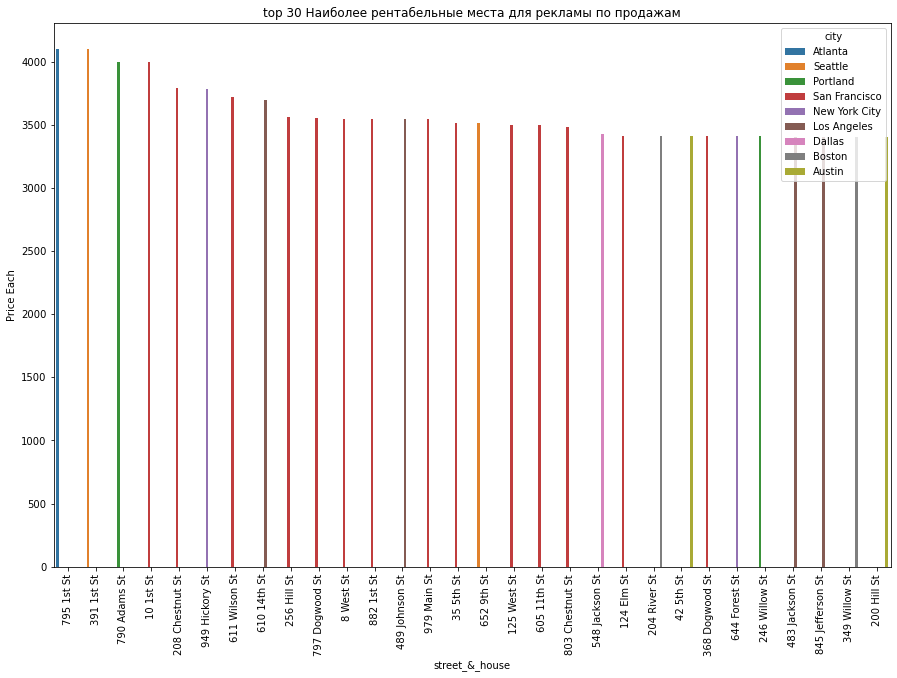

In [17]:
fig, ax_1 = plt.subplots(figsize=(15, 10))
sns.barplot(data=df.groupby(['city', 'street_&_house'])['Price Each']
             .sum('Price Each')
             .reset_index()
             .sort_values('Price Each', ascending=False).head(30), x='street_&_house', y='Price Each', hue='city', ax=ax_1)
plt.title('top 30 Наиболее рентабельные места для рекламы по продажам')
plt.xticks(rotation=90)
plt.show()

В соответствии с графиком можно понять какие места и в каких городах наиболее рентабельны для рекламы с точки зрения продаж и выручки

### Какие продукты чаще всего продаются вместе

In [18]:
df['Quantity Price'] = df['Quantity Ordered'] * df['Price Each']

In [19]:
series_products_together_list = df.groupby('Order ID')['Product'].agg(lambda series: set(series.tolist()))
series_products_together_string = df.groupby('Order ID')['Product'].agg(lambda series: ', '.join(set(series.tolist())))

In [20]:
mask_together = series_products_together_list.apply(lambda row: False if len(row)<2 else True)
df_product_together = series_products_together_string[mask_together].reset_index().groupby('Product').count().sort_values('Order ID', ascending=False)

In [21]:
display(df_product_together[df_product_together['Order ID']>1].reset_index().head(10))
display(df_product_together[df_product_together['Order ID']>1].reset_index().tail())

Product  Order ID
0                 Lightning Charging Cable, iPhone       895
1               USB-C Charging Cable, Google Phone       869
2                         iPhone, Wired Headphones       361
3            Vareebadd Phone, USB-C Charging Cable       318
4                   Wired Headphones, Google Phone       311
5                 iPhone, Apple Airpods Headphones       299
6         Bose SoundSport Headphones, Google Phone       169
7                Vareebadd Phone, Wired Headphones       110
8  Lightning Charging Cable, AA Batteries (4-pack)       103
9   Lightning Charging Cable, USB-C Charging Cable        96

Product  Order ID
164                         iPhone, LG Washing Machine         2
165          Lightning Charging Cable, Vareebadd Phone         2
166  Lightning Charging Cable, iPhone, AA Batteries...         2
167               34in Ultrawide Monitor, 20in Monitor         2
168                           27in FHD Monitor, iPhone         2

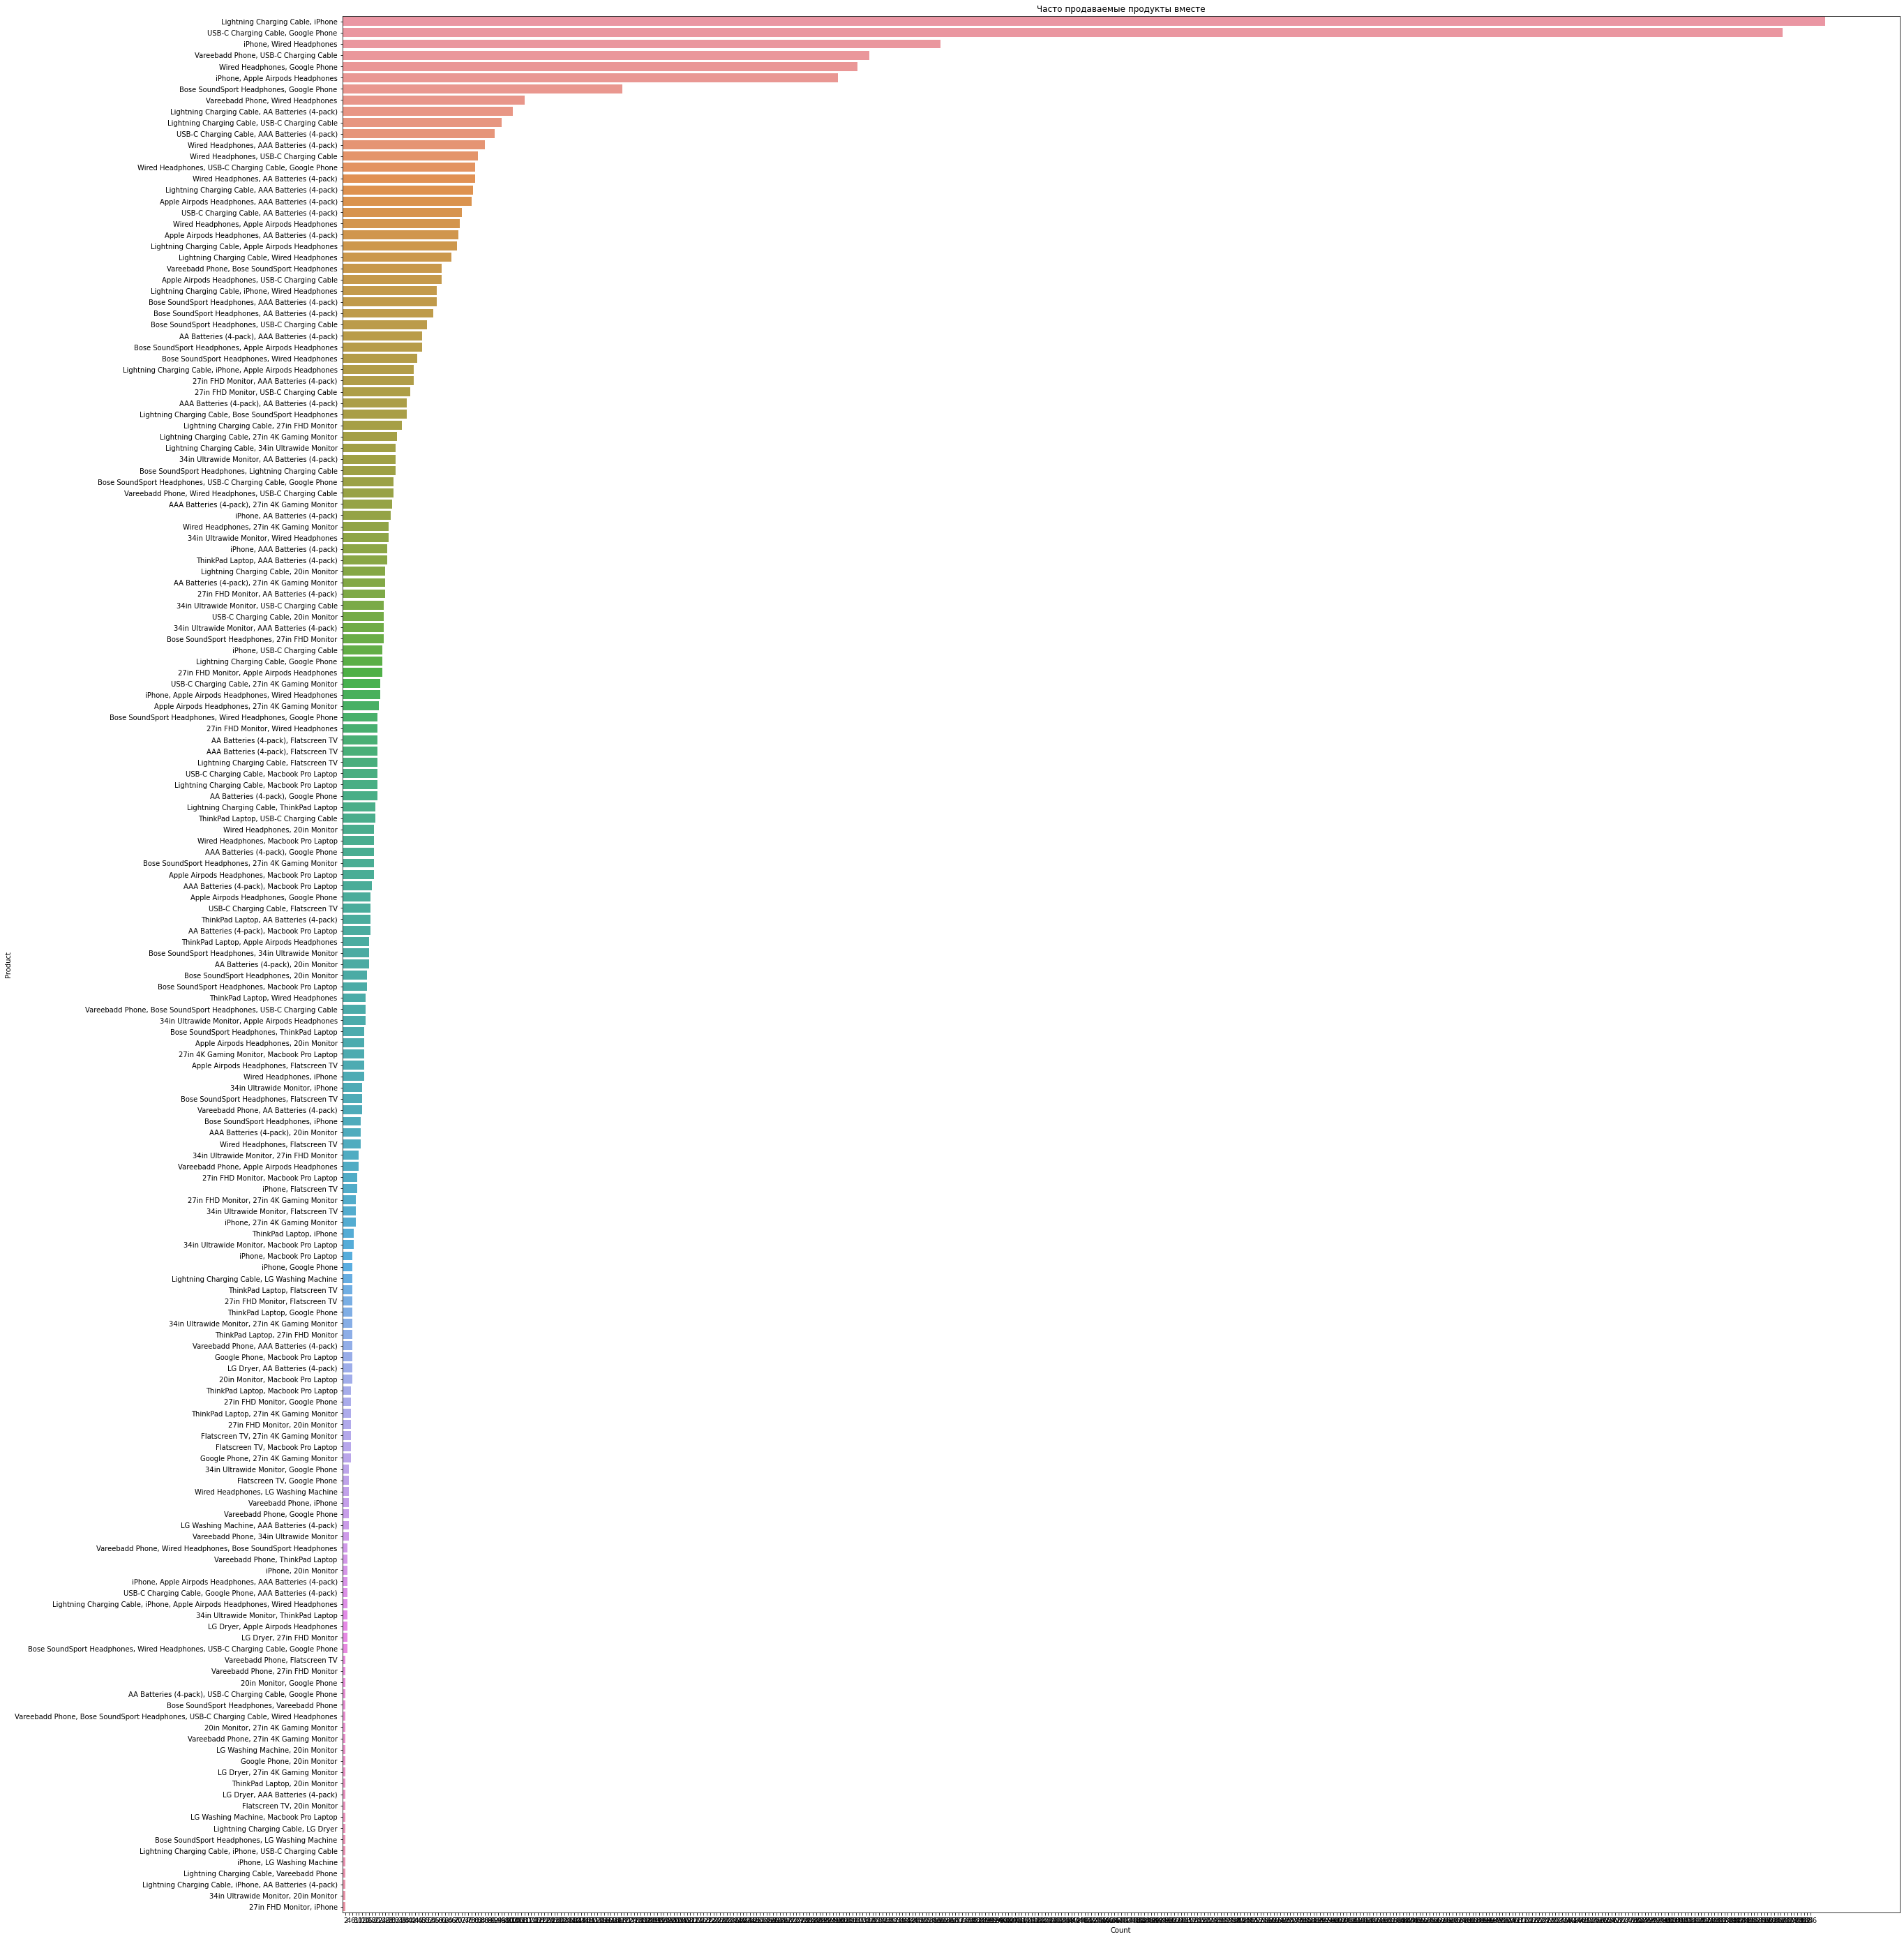

In [22]:
fig, ax_2 = plt.subplots(figsize=(40, 50))
sns.barplot(data=df_product_together[df_product_together['Order ID']>1].reset_index(), y='Product', x='Order ID', ax=ax_2)
plt.title('Часто продаваемые продукты вместе')
plt.xlabel('Count')
ax_2.set_xticks(range(2, 887, 2))
plt.show()

In [23]:
display(df_product_together[df_product_together['Order ID']>1].reset_index().head(15))
display(df_product_together[df_product_together['Order ID']>1].reset_index().tail(15))

Product  Order ID
0                    Lightning Charging Cable, iPhone       895
1                  USB-C Charging Cable, Google Phone       869
2                            iPhone, Wired Headphones       361
3               Vareebadd Phone, USB-C Charging Cable       318
4                      Wired Headphones, Google Phone       311
5                    iPhone, Apple Airpods Headphones       299
6            Bose SoundSport Headphones, Google Phone       169
7                   Vareebadd Phone, Wired Headphones       110
8     Lightning Charging Cable, AA Batteries (4-pack)       103
9      Lightning Charging Cable, USB-C Charging Cable        96
10       USB-C Charging Cable, AAA Batteries (4-pack)        92
11           Wired Headphones, AAA Batteries (4-pack)        86
12             Wired Headphones, USB-C Charging Cable        82
13  Wired Headphones, USB-C Charging Cable, Google...        80
14            Wired Headphones, AA Batteries (4-pack)        80

Product  Order ID
154                   LG Washing Machine, 20in Monitor         2
155                         Google Phone, 20in Monitor         2
156                   LG Dryer, 27in 4K Gaming Monitor         2
157                      ThinkPad Laptop, 20in Monitor         2
158                   LG Dryer, AAA Batteries (4-pack)         2
159                        Flatscreen TV, 20in Monitor         2
160             LG Washing Machine, Macbook Pro Laptop         2
161                 Lightning Charging Cable, LG Dryer         2
162     Bose SoundSport Headphones, LG Washing Machine         2
163  Lightning Charging Cable, iPhone, USB-C Chargi...         2
164                         iPhone, LG Washing Machine         2
165          Lightning Charging Cable, Vareebadd Phone         2
166  Lightning Charging Cable, iPhone, AA Batteries...         2
167               34in Ultrawide Monitor, 20in Monitor         2
168                           27in FHD Monitor, iPhone         2

Соответственно, по данной столбчатой диаграмме можно увидеть какие товары продаются чаще других вместе. В основном это смартфон,  наушники(гарнитура), и кабель для зарядки.

Данные товары продаются чаще всего, возможно, по той причине, что телефон продается отдельно с гарнитурой и кабелем для зарядки.

### Association rules-apriori algorithm

Говоря простым языком, это алгоритм, который определяет, покупая один товар, покупатель покупает чаще ещё что-то(другой товар).
Можно использовать просто модуль, но мы реализуем упрощенный алгоритм в ручную, а потом проверить нашу реализацию, на модуле `efficient_apriori`.

Пропишим план действий:
* посчитать support как просто Probability(A);
* посчитать confidence как Probability(A & B) / Support(A);
* посчитать lift;

*support - это вероятность купить какой-либо выбранный нами продукт. Confidence - это уверенность в том, что будет куплен один предмет, когда куплен другой. lift - это коэффициент, показыающий, что на сколько сильная взаимосвязь между товарами.

In [24]:
# df = pd.DataFrame([['Eggs', 'Bacon', 'Soup', 'Eggs', 'Bacon', 'Apple', 'Eggs', 'Bacon', 'Apple', 'Soup', 'Bacon', 'Banana', 'Banana', 'Butter', '', 'Butter', '', ''],
#         [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6]]).T


# df.columns=['Product', 'Order ID']
# df

In [25]:
def clear_couple(couple):
    return set(filter(lambda list_products: list_products != '', re.sub(r'{string}[,]\s|{string}'.format(string=row['index']), '', couple, flags=re.I).split(', ')))


def find_quantity(func, *args):
    def inner(*args):
        set_rows, flag = args
        if flag==False:
            count_list = [1 if len(set_rows.intersection(set_row)) == len(set_rows)\
                        and row['index'].lower() in set_row else 0 \
                                    for set_row in df_products_together_list['set_product'].tolist()]
            
        elif flag==True:
            count_list = [1 if len(set_rows.intersection(set_row)) == len(max(set_rows, set_row, key=len))\
                        and row['index'].lower() in set_row else 0 \
                                    for set_row in df_products_together_list['set_product'].tolist()]
        return func(count_list)
    return inner


@find_quantity
def count_quantity(count_list):
    return sum(count_list)

    
        
def clear_string(set_rows):
    return set(filter(lambda row: row != '', [re.sub(r'[,]$', '', row) for row in set_rows]))

list_products = ['usb-c charging cable', 'iPhone', 'Google Phone', 'Wired Headphones']

df['Product'] = df['Product'].apply(lambda row: row.lower())

series_products_together_list = df\
                                .groupby('Order ID')['Product']\
                                .agg(lambda series: set(series.tolist()))

df_products_together_list = series_products_together_list.apply(clear_string)
df_products_together_list = df_products_together_list.to_frame()

df_products_together_list.columns = ['set_product']
df_products_together_list['Product'] = None

df_products_together_list['Product'] = df_products_together_list['set_product'].apply(lambda row: ', '.join(row))
df_product_together = df_products_together_list.groupby('Product').count().reset_index()
df_product_together.columns = ['Product', 'count']

In [26]:



# df_probability_2 = pd.DataFrame(index=df.Product.unique()[df.Product.unique()!=''], 
#                               columns=['A_support', 'confidence', 'A_&_B', 'B', 'B_support', 'lift'])

df_probability_2 = pd.DataFrame(index=list_products, 
                               columns=['A_support', 'confidence', 'A_&_B', 'B', 'B_support', 'lift'])
display(df_probability_2)
# переиндексируем данные
df_products_together_list['count'] =  df_products_together_list\
                                            .reset_index()\
                                            .groupby('Product')['set_product']\
                                            .transform('count')\
                                            .tolist()
df_product_together_res_idx = df_products_together_list.drop_duplicates('Product')

all_count = df['Order ID'].nunique()
# Находим общее количество всех заказов
print('Проверка', df_product_together_res_idx['count'].sum(), df['Order ID'].nunique())

# расчет support
for label, row in df_probability_2.reset_index().iterrows():
    df_product_together_res_idx['target'] = False
# Находим все строки с данным продуктом от одной позиции в заказе, до нескольких позиций разного товара
    df_product_together_res_idx.loc[df_product_together_res_idx['Product'].str.contains(pat=r'{string}'.format(string=row['index']),
                                                             case=False,
                                                             regex=True), 'target'] = 1
# Считаем support как отношение заказов с конкретным продуктом к всем заказам
    df_probability_2.loc[row['index'], 'A_support'] = df_product_together_res_idx[df_product_together_res_idx['target']==1]['count']\
                                                             .sum()/all_count
    
    counts_arr = list(map(lambda set_rows: count_quantity(set_rows, True), 
                                                            df_product_together_res_idx['set_product']))
    
    if sum(counts_arr) != 0:
        counts_arr = np.array(list(filter(lambda x: x!= 0, counts_arr)))
    else:
        counts_arr = np.array(counts_arr)
    df_probability_2.loc[row['index'], 'confidence'] = (counts_arr/all_count)/df_probability_2.loc[row['index'], 
                                                                                                'A_support']

    # расчет confidence
# Считаем confidence как отношение заказов с сочитанием конкретных продуктов вместе с определенным товаром к всем заказам
    df_probability_2.loc[row['index'], 'A_&_B'] = df_product_together_res_idx[df_product_together_res_idx['target']==1]['Product'].tolist()
    df_probability_2.loc[row['index'], 'B'] = df_product_together_res_idx[df_product_together_res_idx['target']==1]['Product'].apply(clear_couple).tolist()
    df_probability_2.loc[row['index'], 'B_support'] = list(map(lambda set_rows: count_quantity(set_rows, False), 
                                                            df_probability_2.loc[row['index'], 'B'], ))
    
df_probability_2 = df_probability_2.explode(['confidence', 'A_&_B', 'B', 'B_support'])
df_probability_2['B_support'] = df_probability_2['B_support']/all_count
# расчет lift
df_probability_2.loc[df_probability_2['B']!=set([]), 'lift'] =df_probability_2.loc[df_probability_2['B']!=set([]), 'confidence'] / df_probability_2['B_support'].loc[df_probability_2['B']!=set([])]
     

A_support confidence A_&_B    B B_support lift
usb-c charging cable       NaN        NaN   NaN  NaN       NaN  NaN
iPhone                     NaN        NaN   NaN  NaN       NaN  NaN
Google Phone               NaN        NaN   NaN  NaN       NaN  NaN
Wired Headphones           NaN        NaN   NaN  NaN       NaN  NaN

Проверка 178437 178437


C:\Users\qdz91\AppData\Local\Temp/ipykernel_26144/305568080.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_product_together_res_idx['target'] = False
C:\Users\qdz91\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [27]:
# for product_row in list_products:
#     print(len(df_probability_2.loc[product_row, 'confidence']))
#     print(len(df_probability_2.loc[product_row, 'A_&_B']))
#     print(len(df_probability_2.loc[product_row, 'B']))
#     print(len(df_probability_2.loc[product_row, 'B_support']))
#     print()

In [28]:
for product in list_products:
    for label, row in df_probability_2[df_probability_2.index==product].sort_values('lift', ascending=False).head(1).iterrows():
        print(f'{label} - Вероятность купить {row.A_support}, наибольшая вероятность взять его с товарами ({row["A_&_B"]}) равна коэффициенту подъема {row.lift}', end='\n\n')

usb-c charging cable - Вероятность купить 0.12248020309689134, наибольшая вероятность взять его с товарами (usb-c charging cable, google phone, apple airpods headphones, wired headphones) равна коэффициенту подъема 8.16458476321208

iPhone - Вероятность купить 0.03833285697473058, наибольшая вероятность взять его с товарами (usb-c charging cable, vareebadd phone, iphone) равна коэффициенту подъема 26.087280701754388

Google Phone - Вероятность купить 0.0309464965225822, наибольшая вероятность взять его с товарами (usb-c charging cable, google phone, apple airpods headphones, wired headphones) равна коэффициенту подъема 32.31383556682361

Wired Headphones - Вероятность купить 0.10562271277817942, наибольшая вероятность взять его с товарами (usb-c charging cable, google phone, apple airpods headphones, wired headphones) равна коэффициенту подъема 9.46766063564493



In [29]:
print(f'Вероятность купить следующие товары: {[row for row in df_probability_2.index.unique()]}.')
print(f'Соответствующие вероятноси: {[row for row in df_probability_2.A_support.unique()]}.')

Вероятность купить следующие товары: ['usb-c charging cable', 'iPhone', 'Google Phone', 'Wired Headphones'].
Соответствующие вероятноси: [0.12248020309689134, 0.03833285697473058, 0.0309464965225822, 0.10562271277817942].


Теперь сравним с готовым модулем по данному алгоритму.

In [30]:
itemsets, rules = apriori(series_products_together_list.tolist(), min_support=0.001, 
                          min_confidence=0.002, 
                          max_length=2000)
for item in sorted(rules, key=lambda item: (item.lift,item.conviction), reverse=True):
    print(item)

{google phone} -> {usb-c charging cable} (conf: 0.181, supp: 0.006, lift: 1.474, conv: 1.071)
{usb-c charging cable} -> {google phone} (conf: 0.046, supp: 0.006, lift: 1.474, conv: 1.015)
{vareebadd phone} -> {usb-c charging cable} (conf: 0.178, supp: 0.002, lift: 1.455, conv: 1.068)
{usb-c charging cable} -> {vareebadd phone} (conf: 0.017, supp: 0.002, lift: 1.455, conv: 1.005)
{iphone} -> {lightning charging cable} (conf: 0.148, supp: 0.006, lift: 1.221, conv: 1.031)
{lightning charging cable} -> {iphone} (conf: 0.047, supp: 0.006, lift: 1.221, conv: 1.009)
{wired headphones} -> {google phone} (conf: 0.022, supp: 0.002, lift: 0.724, conv: 0.991)
{google phone} -> {wired headphones} (conf: 0.076, supp: 0.002, lift: 0.724, conv: 0.968)
{wired headphones} -> {iphone} (conf: 0.025, supp: 0.003, lift: 0.639, conv: 0.986)
{iphone} -> {wired headphones} (conf: 0.068, supp: 0.003, lift: 0.639, conv: 0.959)
{apple airpods headphones} -> {iphone} (conf: 0.024, supp: 0.002, lift: 0.627, conv: 0

### Вывод по работе

Самым наиболее заработываемым годом был 2019, но с точки зрения анализа данные собраны не корректно. Возможно можно было бы разбить успех продаж на кварталы в таком случае.

Наиболее успешным месяцем считается декабрь. В принципе, что очень логично, так как этот месяц предпраздничный.

Больше всего продаж было в горооде San Francisco в количестве 44732 заказов.

Наиболее подходящие места по месту рекламы являются: Atlanta 795 1st St, Seattle 391 1st St, San Francisco	10 1st St и т.д., но данных по затратам на рекламу в данных городах и местах нет, таким образом анализ сделан с точки зрения выручки.

В ходе анализа вероятности купить товары: 'usb-c charging cable', 'iPhone', 'Google Phone', 'Wired Headphones' было выяснено, что веротяность куупить данные товары достаточно мала, ниже 13%, что говорит об особенности бизнеса и товара, так как товар не скоропортящийся. Таким образом больший фокус данного бизнеса я бы сфокусировал на удержании клиентов и покупателей. Так же можно всоответсвии с коэффициентом подъема(lift) предположить перестановку в магазине и дизайн, и архитектуру веб-приложения по продаже товаров бытовой техники, так как при достаточно выскоком взаимодействи, допустим iPhone с товарами  vareebadd phone, usb-c charging cable, есть предполжение и предложение, что стоит на полках товаров располагать их рядом, а на сайтах не просто распологать рядом в рекомендациях при покупках, а даже провести аб-тесты c всплывающим окнами с предложением покупки дополнительно данных товаров,для определния лучшей тактики взаимодействия с клиентом и улучшения выручки.